In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = F.sigmoid(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        # x = x.view(-1, 16*5*5)
        x = torch.flatten(x, 1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Parameters
batch_size = 256
num_epochs = 5
lr = 0.001

model = LeNet()

if CUDA:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [5]:
# Transform
transform = transforms.Compose(
                [transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),]
                )

# Data
train_dataset = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
valid_dataset = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [14]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = model(data) 
        loss = criterion(output, target) 

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += sum((predicted == target).float())
        train_loss += loss.item()

        # if batch_idx % 100 == 0:
        #     print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
        #        epoch+1, num_epochs, batch_idx+1, len(train_loader),
        #        correct_train / float((batch_idx + 1) * batch_size),
        #        train_loss / float((batch_idx + 1) * batch_size)))
            
    train_acc_ = 100 * (correct_train / float(total_train))
    train_loss_ = train_loss / total_train
                    
    return train_acc_, train_loss_

In [15]:
def validate(valid_loader, model, criterion, epoch): 
    model.eval()
    total_valid = 0
    correct_valid = 0
    valid_loss = 0
    
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        # Forward propagation
        output = model(data)
        loss = criterion(output, target) 

        predicted = torch.max(output.data, 1)[1]
        total_valid += len(target)
        correct_valid += sum((predicted == target).float())
        valid_loss += loss.item()

        # if batch_idx % 100 == 0:
        #     print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
        #        epoch+1, num_epochs, batch_idx+1, len(valid_loader),
        #        correct_valid / float((batch_idx + 1) * batch_size),
        #        valid_loss / float((batch_idx + 1) * batch_size)))
            
    valid_acc_ = 100 * (correct_valid / float(total_valid))
    valid_loss_ = valid_loss / total_valid
                    
    return valid_acc_, valid_loss_

In [16]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader):
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(num_epochs):
        # training
        train_acc_, train_loss_ = train(train_loader, model, criterion, optimizer, epoch)
        total_train_loss.append(train_loss_)
        total_train_accuracy.append(train_acc_)

        # validation
        with torch.no_grad():
            valid_acc_, valid_loss_ = validate(valid_loader, model, criterion, epoch)
            total_valid_loss.append(valid_loss_)
            total_valid_accuracy.append(valid_acc_)

        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, num_epochs, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))

    print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [17]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/5， Train acc： 96.315002， Train loss： 0.000491， Valid acc： 96.660004， Valid loss： 0.000428
Epoch: 2/5， Train acc： 96.720001， Train loss： 0.000428， Valid acc： 97.010002， Valid loss： 0.000391
Epoch: 3/5， Train acc： 97.061668， Train loss： 0.000384， Valid acc： 97.150002， Valid loss： 0.000349
Epoch: 4/5， Train acc： 97.366669， Train loss： 0.000347， Valid acc： 97.559998， Valid loss： 0.000304
Epoch: 5/5， Train acc： 97.566673， Train loss： 0.000321， Valid acc： 97.470001， Valid loss： 0.000311
====== END ==========


In [26]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(num_epochs), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(num_epochs), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

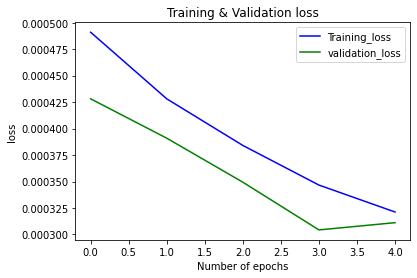

In [27]:
plot_result(total_train_loss, total_valid_loss, 'loss')

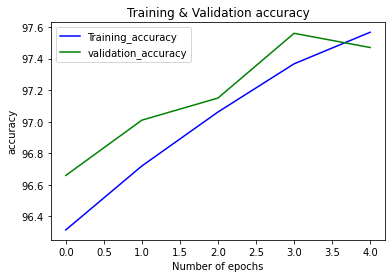

In [28]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')